In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/journey-springfield/sample_submission.csv
/kaggle/input/journey-springfield/characters_illustration.png
/kaggle/input/journey-springfield/testset/testset/img516.jpg
/kaggle/input/journey-springfield/testset/testset/img254.jpg
/kaggle/input/journey-springfield/testset/testset/img263.jpg
/kaggle/input/journey-springfield/testset/testset/img659.jpg
/kaggle/input/journey-springfield/testset/testset/img575.jpg
/kaggle/input/journey-springfield/testset/testset/img0.jpg
/kaggle/input/journey-springfield/testset/testset/img403.jpg
/kaggle/input/journey-springfield/testset/testset/img976.jpg
/kaggle/input/journey-springfield/testset/testset/img224.jpg
/kaggle/input/journey-springfield/testset/testset/img985.jpg
/kaggle/input/journey-springfield/testset/testset/img514.jpg
/kaggle/input/journey-springfield/testset/testset/img170.jpg
/kaggle/input/journey-springfield/testset/testset/img212.jpg
/kaggle/input/journey-springfield/testset/testset/img280.jpg
/kaggle/input/journey-springfi

### Установка зависимостей

In [3]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
import PIL
print(PIL.__version__)

9.5.0


In [5]:
!nvidia-smi
import torch
torch.cuda.is_available()

Fri Apr  5 08:48:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              26W / 250W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

In [6]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


### Загрузка и обработка картинок

In [7]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [8]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [10]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('/kaggle/input/journey-springfield/train/')
TEST_DIR = Path('/kaggle/input/journey-springfield/testset')

In [11]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [12]:
train_val_files[:5]

[PosixPath('/kaggle/input/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg'),
 PosixPath('/kaggle/input/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0001.jpg'),
 PosixPath('/kaggle/input/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0002.jpg'),
 PosixPath('/kaggle/input/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0003.jpg'),
 PosixPath('/kaggle/input/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0004.jpg')]

### Разделим на обучающее и валидационное подмножества

In [13]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [14]:
train_dataset = SimpsonsDataset(train_val_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')

In [15]:
# uncomment if you have problem with pillow
def register_extension(id, extension):
    Image.EXTENSION[extension.lower()] = id.upper()
    Image.register_extension = register_extension
def register_extensions(id, extensions):
    for extension in extensions:
        register_extension(id, extension)
        Image.register_extensions = register_extensions

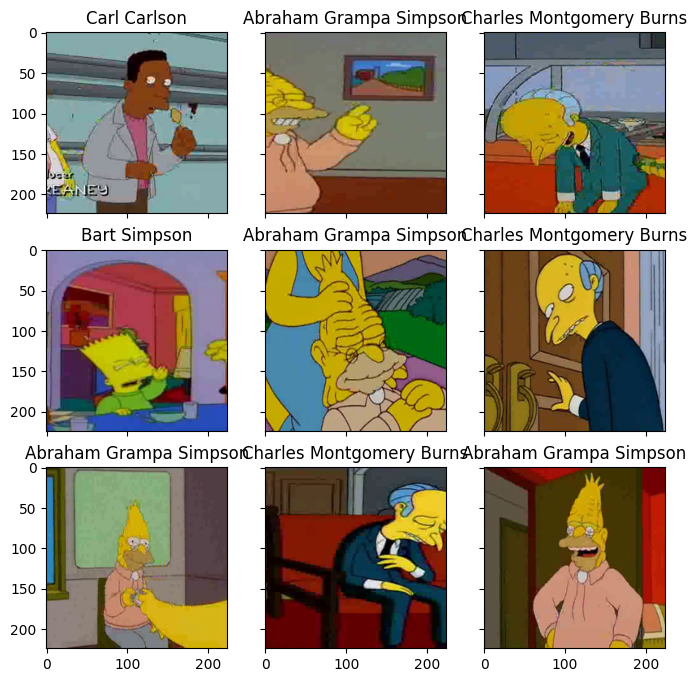

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Необходимые функции для обучения

In [17]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [18]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [19]:
def fine_train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=1e-4)
        criterion = nn.CrossEntropyLoss()
        
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=3, gamma=0.05)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [20]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

### Загружаем предобученную модель ResNET34

In [21]:
from torchvision import models
models.resnet34(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 158MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Изменяем последний полносвязный слой. Делаем сеть обучаемую по всем слоям (не замораживаем корпус сети)

In [22]:
n_classes = len(np.unique(train_val_labels))
model = models.resnet34(pretrained=True)

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 512
# Заменяем Fully-Connected слой на наш линейный классификатор
model.fc = nn.Linear(num_features, n_classes)

resnet = model.to(DEVICE)
print("We will classify :{}".format(n_classes))
print(resnet)

We will classify :42
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): 

### Обучаем сеть

In [23]:
history_3 = fine_train(train_dataset, val_dataset, model=resnet, epochs=15, batch_size=128)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 0.6682305260492579


epoch:   7%|▋         | 1/15 [05:24<1:15:37, 324.09s/it]


Epoch 001 train_loss: 0.6682     val_loss 0.1097 train_acc 0.8529 val_acc 0.9807
loss 0.1830926353625018


epoch:  13%|█▎        | 2/15 [09:24<59:37, 275.16s/it]  


Epoch 002 train_loss: 0.1831     val_loss 0.1031 train_acc 0.9525 val_acc 0.9740
loss 0.08318489368120313


epoch:  20%|██        | 3/15 [13:25<51:53, 259.42s/it]


Epoch 003 train_loss: 0.0832     val_loss 0.0534 train_acc 0.9791 val_acc 0.9855
loss 0.051880363255179696


epoch:  27%|██▋       | 4/15 [17:25<46:09, 251.78s/it]


Epoch 004 train_loss: 0.0519     val_loss 0.0314 train_acc 0.9857 val_acc 0.9903
loss 0.03870393015130709


epoch:  33%|███▎      | 5/15 [21:28<41:25, 248.59s/it]


Epoch 005 train_loss: 0.0387     val_loss 0.0252 train_acc 0.9883 val_acc 0.9927
loss 0.03782048150299072


epoch:  40%|████      | 6/15 [25:27<36:46, 245.13s/it]


Epoch 006 train_loss: 0.0378     val_loss 0.0350 train_acc 0.9892 val_acc 0.9895
loss 0.033223426181924275


epoch:  47%|████▋     | 7/15 [29:24<32:21, 242.67s/it]


Epoch 007 train_loss: 0.0332     val_loss 0.0052 train_acc 0.9902 val_acc 0.9985
loss 0.025162822373859344


epoch:  53%|█████▎    | 8/15 [33:22<28:07, 241.04s/it]


Epoch 008 train_loss: 0.0252     val_loss 0.0440 train_acc 0.9934 val_acc 0.9872
loss 0.016880774293398966


epoch:  60%|██████    | 9/15 [37:25<24:11, 241.86s/it]


Epoch 009 train_loss: 0.0169     val_loss 0.0093 train_acc 0.9954 val_acc 0.9960
loss 0.012850973627855755


epoch:  67%|██████▋   | 10/15 [41:31<20:14, 242.91s/it]


Epoch 010 train_loss: 0.0129     val_loss 0.0079 train_acc 0.9964 val_acc 0.9966
loss 0.020153063040972183


epoch:  73%|███████▎  | 11/15 [45:34<16:11, 242.99s/it]


Epoch 011 train_loss: 0.0202     val_loss 0.0103 train_acc 0.9940 val_acc 0.9973
loss 0.02001760811797884


epoch:  80%|████████  | 12/15 [49:38<12:10, 243.37s/it]


Epoch 012 train_loss: 0.0200     val_loss 0.0384 train_acc 0.9940 val_acc 0.9893
loss 0.025667295490001546


epoch:  87%|████████▋ | 13/15 [53:43<08:07, 243.93s/it]


Epoch 013 train_loss: 0.0257     val_loss 0.0234 train_acc 0.9929 val_acc 0.9939
loss 0.019727345908119663


epoch:  93%|█████████▎| 14/15 [57:50<04:04, 244.63s/it]


Epoch 014 train_loss: 0.0197     val_loss 0.0088 train_acc 0.9948 val_acc 0.9975
loss 0.012180475126044768


epoch: 100%|██████████| 15/15 [1:01:47<00:00, 247.18s/it]


Epoch 015 train_loss: 0.0122     val_loss 0.0118 train_acc 0.9967 val_acc 0.9968


In [24]:
loss_3, acc_3, val_loss_3, val_acc_3 = zip(*history_3)

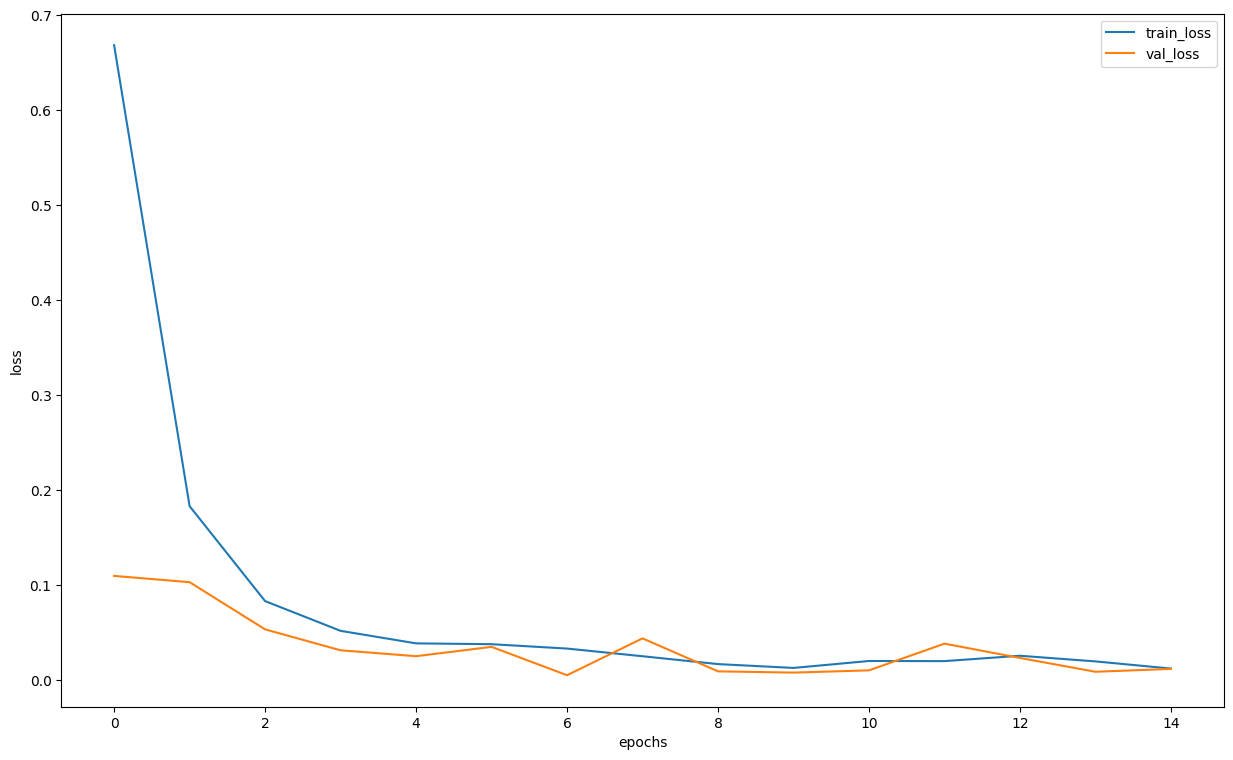

In [25]:
plt.figure(figsize=(15, 9))
plt.plot(loss_3, label="train_loss")
plt.plot(val_loss_3, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

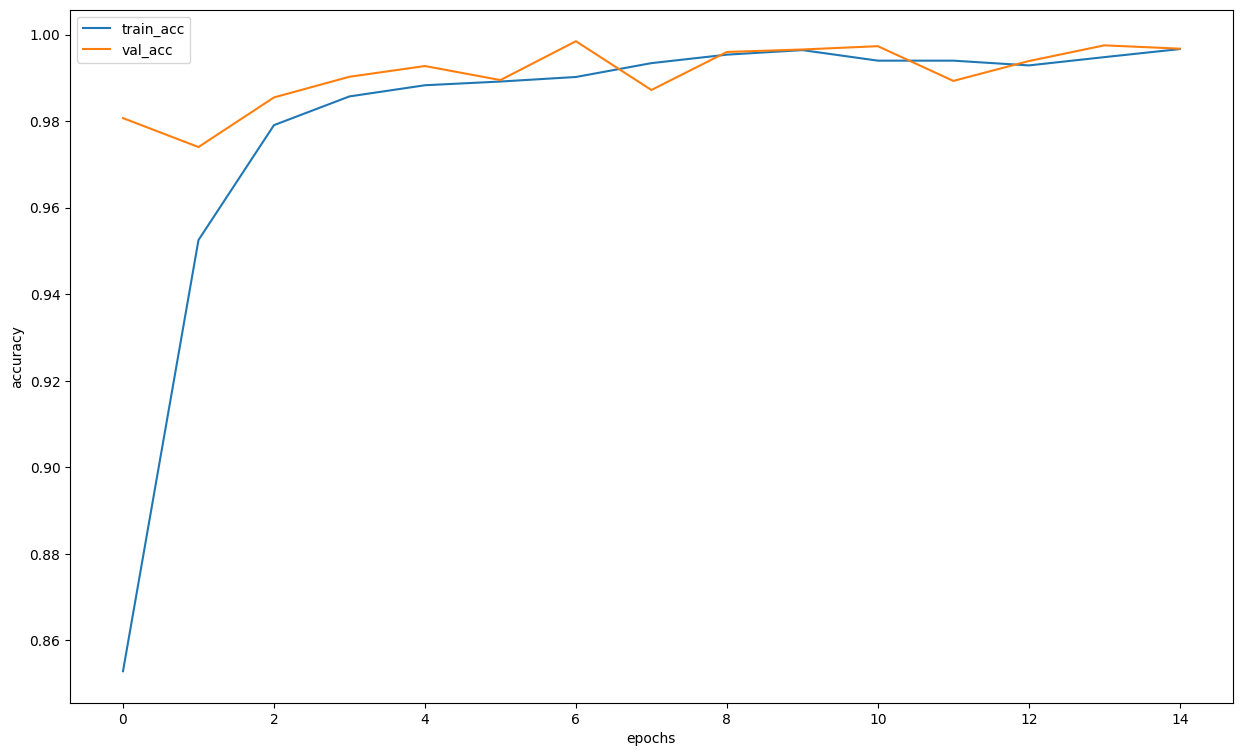

In [26]:
plt.figure(figsize=(15, 9))
plt.plot(acc_3, label="train_acc")
plt.plot([x.to('cpu').numpy() for x in val_acc_3], label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [27]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

probs = predict(resnet, test_loader)

preds_3 = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [32]:
import pandas as pd
my_submit = pd.read_csv("/kaggle/input/journey-springfield/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds_3})

my_submit.to_csv('resnet_34_Timokhin.csv', index=False)

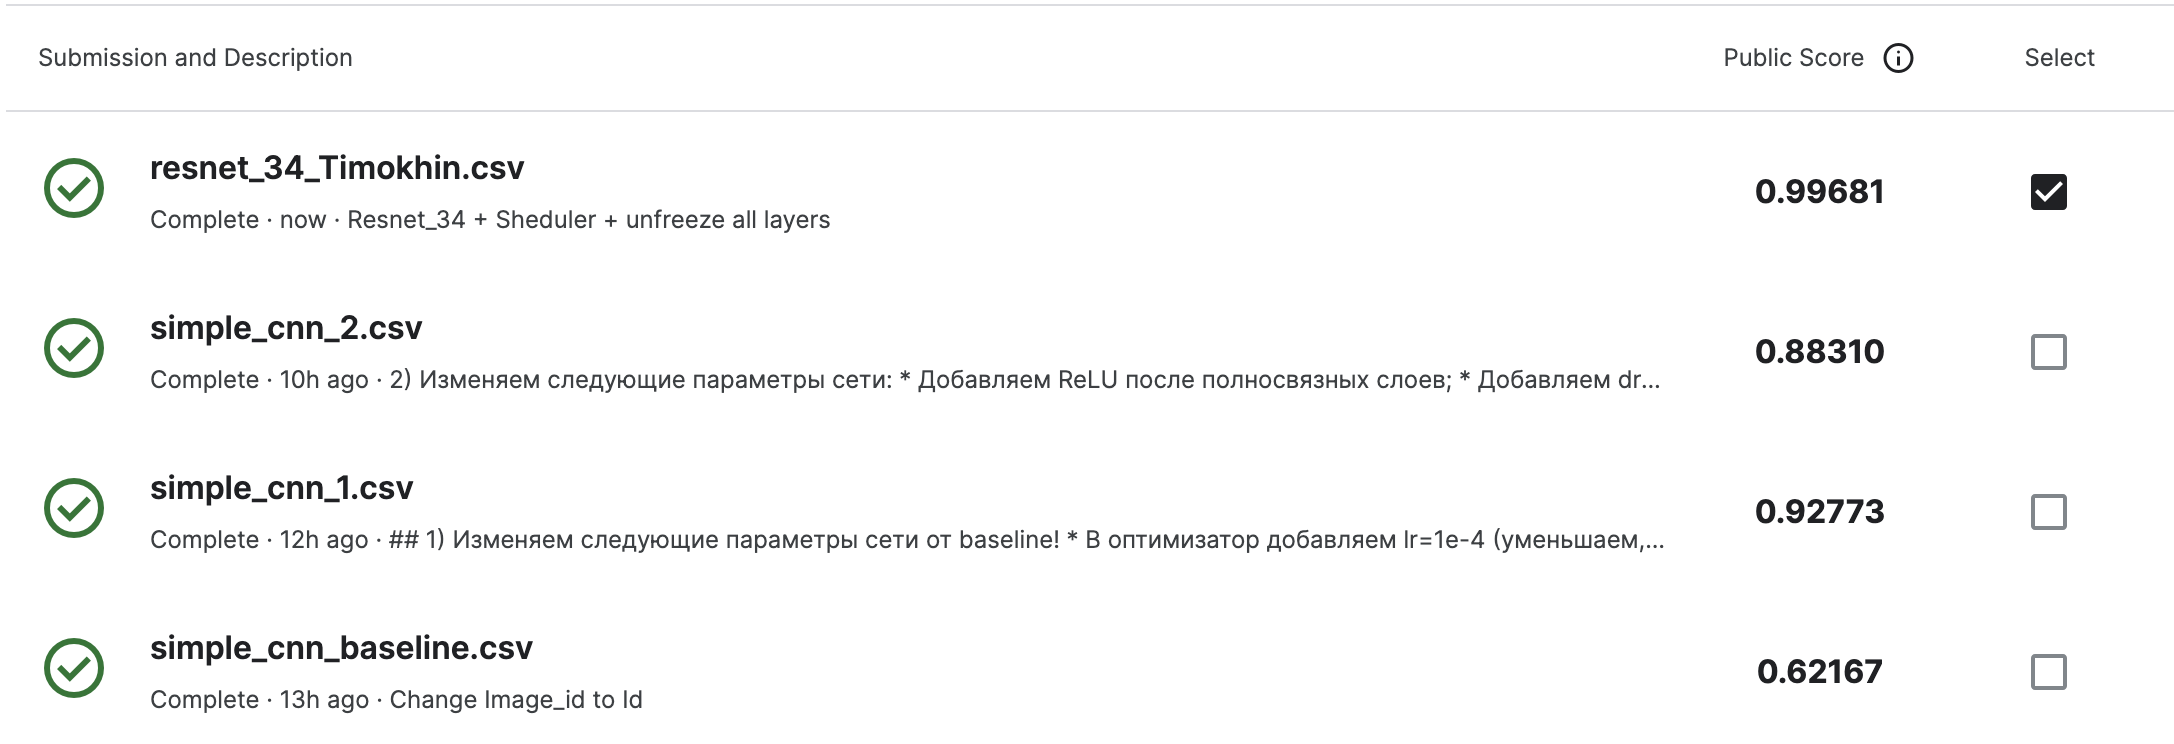

### Проверим предсказания на валидационной подвыборке

In [34]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [35]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(resnet, ex_img.unsqueeze(0))

In [36]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(resnet, imgs)

In [37]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 1.0


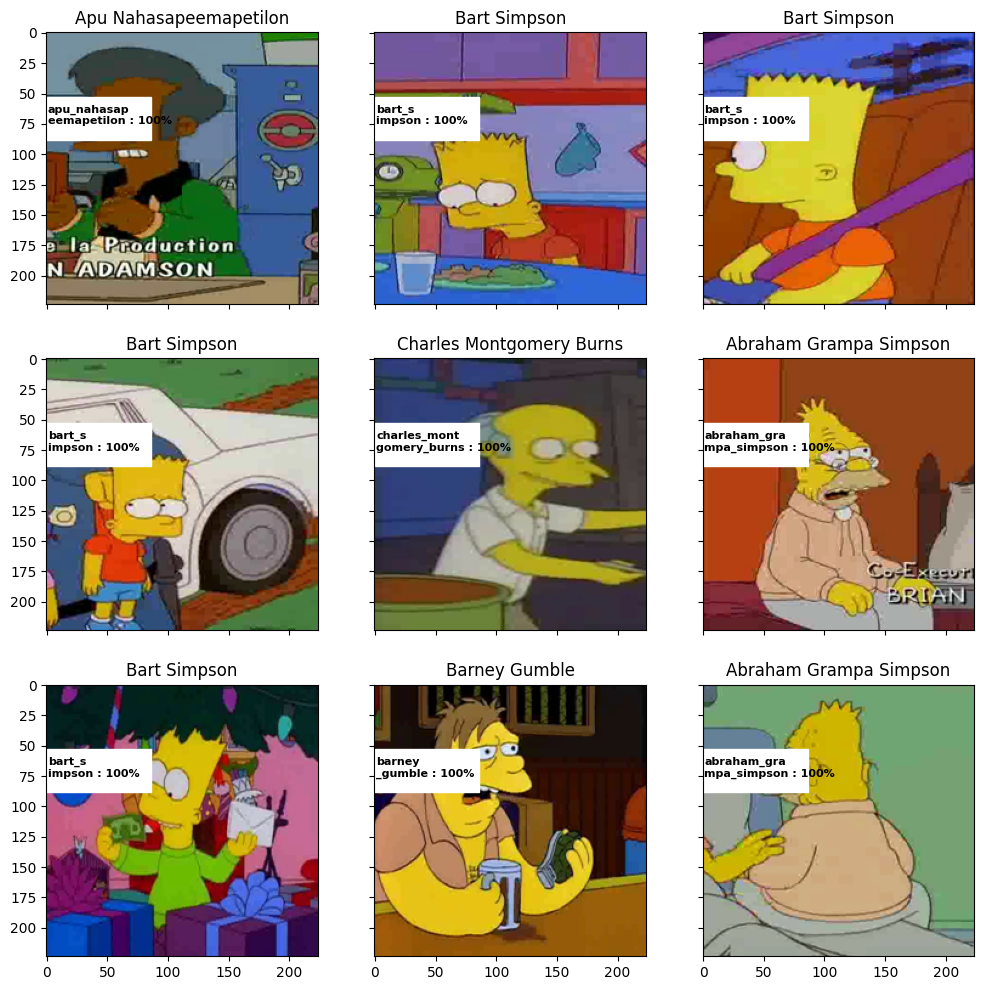

In [38]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(resnet, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

---
# Отчет:
---
## Эксперименты, проводимые и представленные в ноутбуках (все изменения относительно предыдущего эксперимента):

1) Изменение learning_rate, batch_size, epochs + добавление batch_norm;

2) Добавление ReLU, dropout, augmentation, sheduler + изменение оптимизатора на AdamW;

3) Дообучение модели ResNET34 + изменен sheduler + разморозка всех слоев при обучении + изменение оптимизатора на Adam;


    * 4) Также был эксперимент  ~3) пункту только с заморозкой всех слоев, кроме последнего, однако результаты оказались плачевными, в финальных ноутбуках удалил этот блок;

---
## Эксперимент 1 (описание):
* Уменьшение learning_rate в оптимизаторе до 1e-4;
* Увеличение batch_size до 128;
* Увеличение эпох до 15;
* Добавление batch_norm в каждый сверточный слой нейронной сети.

#### Результаты:
**Loss** на трейне снижается в течение всех эпох на валидации останавливается и даже начинает возрастать с 8ой эпохи. Максимальное значение **Accuracy** на **трейне** = 0.99, на **евал** = 0.78. **Accuracy** на **тестовом** дататесе kaggle = 0.92.

* **Плюсы**: Достаточно быстрое обучение, относительно других экспериментов.

* **Минусы**: Переобучение, недостаточное качество.

---
## Эксперимент 2 (описание) - борьба с переобучением:
* Добавление функции активации ReLU на полносвязные слои;
* Добавление dropout после первого полносвязного слоя с p=0.2;
* Добавлена аугментация train_dataset со следующими параметрами в transforms.Compose:
    * transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # изменение настроек изображения
    * transforms.RandomRotation(25), # повороты изоражений
    * transforms.RandomHorizontalFlip(), # отзеркаливание избражений
* Добавление sheduler в оптимизатор, для изменения learning_rate во время обучения (lr_scheduler.ExponentialLR(optimizer=opt, gamma=0.5));
* Изменение оптимизатора с Adam(model.parameters(), lr=1e-4) на AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=0.01).

#### Результаты:
**Loss**  на трейне и валидации модель стабилизируется и переобучение начинается лишь к 15ой эпохе. Максимальное значение **Accuracy** на **трейне** = 0.85, на **евал** = 0.81. **Accuracy** на **тестовом** дататесе kaggle = 0.88.

* **Плюсы**: Стабильность при большом количестве эпох, не переобучается.

* **Минусы**: Обучение более долгое. Недостаточное качество.

---
## Эксперимент 3 (описание) - дообучение модели:
* Основная модель - ResNet34;
* Изменение последнего полносвязного слоя на слой из задачи;
* Изменение sheduler в оптимизатор, для изменения learning_rate во время обучения (lr_scheduler.StepLR(opt, step_size=3, gamma=0.05));
* Изменение оптимизатора обратно на Adam(model.parameters(), lr=1e-4).

#### Результаты:
**Loss**  на трейне и валидации модель ведет себя стабильно и не переобучается. Максимальное значение **Accuracy** на **трейне** = 0.99, на **евал** = 0.99. **Accuracy** на **тестовом** дататесе kaggle = 0.99.

* **Плюсы**: Стабильность при большом количестве эпох, не переобучается.

* **Минусы**: Обучение более долгое. Отличное качество.

---
**ИТОГИ**. Лучшая модель оказалась из третьего эксперимента, с результатом на kaggle = **0.99**

